# Time series prediction of apple stock - Closing price

## Package Install - if necessary

In [8]:
#!conda install --yes -c anaconda pandas-datareader

## Source for the Methodology

https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

## Import necessary libraries

In [7]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM # LSTM - Long Short Term Memory
import matplotlib.pyplot as plt
%matplotlib inline

## Get Stock Data from web

In [9]:
df = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2020-12-20')
#df = web.DataReader('POAHF', data_source='yahoo', start='2012-01-01', end='2020-12-20')

In [10]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,14.732143,14.607143,14.621429,14.686786,302220800.0,12.610315
2012-01-04,14.810000,14.617143,14.642857,14.765714,260022000.0,12.678085
2012-01-05,14.948214,14.738214,14.819643,14.929643,271269600.0,12.818838
2012-01-06,15.098214,14.972143,14.991786,15.085714,318292800.0,12.952841
2012-01-09,15.276786,15.048214,15.196429,15.061786,394024400.0,12.932299


In [11]:
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-12-14,123.349998,121.540001,122.599998,121.779999,79184500.0,121.210495
2020-12-15,127.900002,124.129997,124.339996,127.879997,157243700.0,127.281960
2020-12-16,128.369995,126.559998,127.410004,127.809998,98208600.0,127.212296
2020-12-17,129.580002,128.039993,128.899994,128.699997,94359800.0,128.098129
2020-12-18,129.100006,126.120003,128.960007,126.660004,192541500.0,126.067680


In [12]:
# Get data description
print('Shape: ',df.shape)
df.describe()

Shape:  (2257, 6)


,High,Low,Open,Close,Volume,Adj Close
count,2257.000000,2257.000000,2257.000000,2257.000000,2.257000e+03,2257.000000
mean,38.865175,38.068162,38.465030,38.482219,2.293671e+08,36.618286
std,24.170528,23.478184,23.831019,23.843053,1.800443e+08,24.344315
min,14.271429,13.753571,13.856071,13.947500,4.544800e+07,12.152316
25%,22.851429,22.432142,22.641430,22.631430,1.104816e+08,19.851753
50%,29.937500,29.485001,29.692499,29.760000,1.666164e+08,27.560789
75%,46.797501,45.935001,46.305000,46.365002,2.825928e+08,44.846821
max,137.979996,130.529999,137.589996,134.179993,1.506120e+09,133.322495


## Visualize data of interest

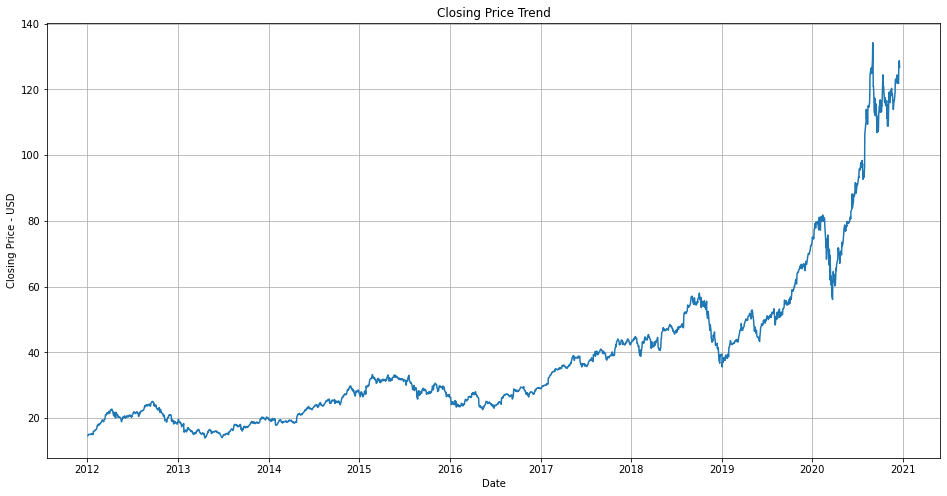

In [13]:
plt.figure(figsize=(16,8))
plt.title('Closing Price Trend')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=10)
plt.ylabel('Closing Price - USD', fontsize = 10)
plt.grid('On')
plt.show()

## Create a new data frame with only 'Close' column - closing price.

In [14]:
data = df.filter(['Close'])
# Convert the data to a numpy array ----> This help us in training
dataset = data.values
# Allot some portion of data to train the model on
training_data_len = math.ceil( len(dataset) *.8)

In [15]:
training_data_len

1806

## Scale the data
This is necessary to train the data. It scales values such that they are between 0 and 1.

In [16]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [17]:
scaled_data
scaled_data.shape

(2257, 1)

## Create the training data set from scaled data

In [18]:
train_data = scaled_data[0:training_data_len,:]
# split data to x_train and y_train
x_train = [] # Independent traing variable
y_train = [] # Dependent training variable

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [19]:
# Convert x_train & y_train to numpy arrays
x_train,y_train=np.array(x_train),np.array(y_train)

In [20]:
# Reshape the data - Because LSTM Expects 3D
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape

(1746, 60, 1)

## Create Testing data set to eavluate our modal

In [21]:
# New scaled values to that was not used in training
# That is from index 1807 to 2256 in the original data set
test_data = scaled_data[training_data_len - 60: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [22]:
# Convert data to numpy
x_test = np.array(x_test)
x_test.shape

(451, 60)

In [23]:
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

# Create Model for training

## Model 1 - LSTM Vanilla

In [26]:
model1 = Sequential()
model1.add(LSTM(50, activation='relu', input_shape=(x_train.shape[1],1)))
model1.add(Dense(1))

NotImplementedError: Cannot convert a symbolic Tensor (lstm_2/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

## Model 2 - LSTM Stacked

In [25]:
# Build the LSTM model
model2 = Sequential()
model2.add(LSTM(50,activation='relu',return_sequences=True,input_shape=(x_train.shape[1],1)))
model2.add(LSTM(50))
model2.add(Dense(25))
model2.add(Dense(1))

NotImplementedError: Cannot convert a symbolic Tensor (lstm_1/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

### Compile the models

In [56]:
model1.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])

In [57]:
model2.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])

### Fit the models

In [58]:
model1.fit(x_train,y_train,batch_size=1,epochs=1)

1746/1746 [==============================] - 54s 31ms/step - loss: 0.0070 - accuracy: 5.7274e-04


In [59]:
model2.fit(x_train,y_train,batch_size=1,epochs=1)

1746/1746 [==============================] - 101s 58ms/step - loss: 0.0025 - accuracy: 5.7274e-04


## Let there be predictions

In [60]:
predictions1 = model1.predict(x_test)
predictions1 = scaler.inverse_transform(predictions1) # Make the scaled data back to dollar value

In [61]:
predictions2 = model2.predict(x_test)
predictions2 = scaler.inverse_transform(predictions2) # Make the scaled data back to dollar value

### Root mean squared error for both models

In [62]:
rmse_model1=np.sqrt(np.mean(((predictions1- y_test)**2)))
rmse_model1

3.7307126733291764

In [63]:
rmse_model2=np.sqrt(np.mean(((predictions2- y_test)**2)))
rmse_model2

2.611483166354268

### Plot the data

In [64]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions_1'] = predictions1
valid['Predictions_2'] = predictions2

<ipython-input-64-2fae9df26f7c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions_1'] = predictions1
<ipython-input-64-2fae9df26f7c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions_2'] = predictions2


## Visualize the data

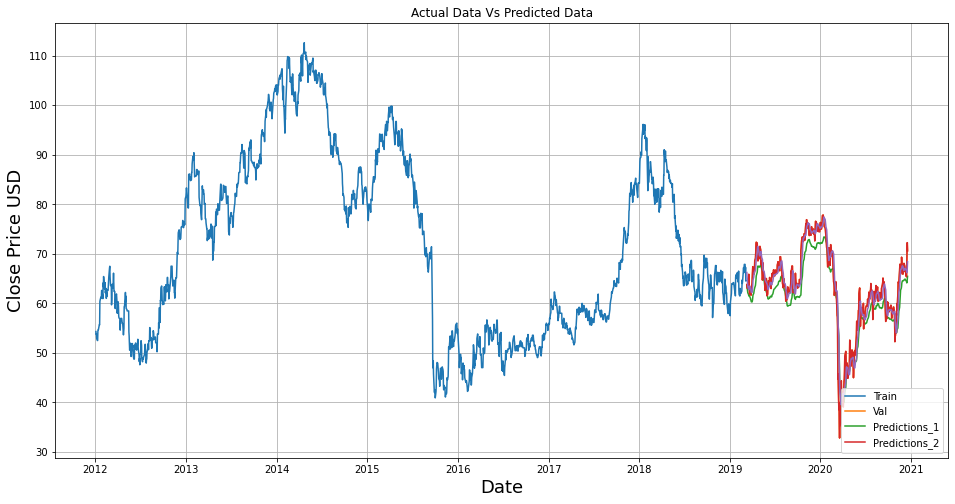

In [65]:
plt.figure(figsize=(16,8))
plt.title('Actual Data Vs Predicted Data')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions_1']])
plt.plot(valid[['Close', 'Predictions_2']])
plt.legend(['Train', 'Val', 'Predictions_1', 'Predictions_2'], loc='lower right')
plt.grid('On')
plt.show()

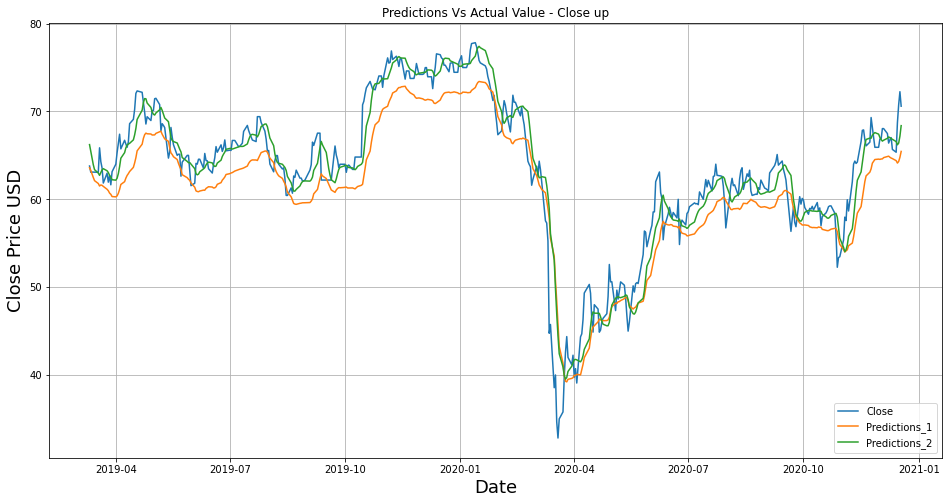

In [66]:
plt.figure(figsize=(16,8))
plt.title('Predictions Vs Actual Value - Close up')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD', fontsize=18)
plt.plot(valid[['Close']])
plt.plot(valid[['Predictions_1']])
plt.plot(valid[['Predictions_2']])
plt.legend(['Close','Predictions_1', 'Predictions_2'], loc='lower right')
plt.grid('On')
plt.show()

In [67]:
valid['Close']

Date
2019-03-11    63.790001
2019-03-12    63.080002
2019-03-13    63.099998
2019-03-14    63.099998
2019-03-15    63.090000
                ...    
2020-12-14    65.360001
2020-12-15    68.699997
2020-12-16    70.750000
2020-12-17    72.250000
2020-12-18    70.599998
Name: Close, Length: 451, dtype: float64